In [2]:
import pandas as pd
import numpy as np


In [3]:
n400 = pd.read_csv("N400_by_trial.csv")
#in case we trian only on the 3 electrodes
n400c = n400[['ItemNum', 'Condition', 'T8', 'PO9', 'P7']]
n400sr = n400[['ItemNum', 'Condition','O1', 'Oz', 'Pz']]
n400sur = n400[['ItemNum', 'Condition','PO9', 'T7', 'O1']]

p600 = pd.read_csv("P600_by_trial.csv")
#in case we trian only on the 3 electrodes
p600c = p600[['ItemNum', 'Condition','T8', 'PO9', 'P7']]
p600sr = p600[['ItemNum', 'Condition','O1', 'Oz', 'Pz']]
p600sur = p600[['ItemNum', 'Condition','PO9', 'T7', 'O1']]
spr = pd.read_csv("SPR_by_trial.csv")

In [4]:
def extract_features(dataframe: pd.DataFrame, condition):
    """
    Extracts features from a dataframe of ERPs / SRP's. 
    
    Args:
        dataframe: A dataframe of ERPs / SRP's.
        condition: The condition to extract features from.
    Returns:
        A numpy array of features.
    """
    
    features = dataframe[dataframe["Condition"] == condition]
    features = features.drop(["Condition"], axis=1)
    features = features.set_index("ItemNum")
    features = np.expand_dims(features.to_numpy(), axis=0)
    return features

n400_control = extract_features(n400, "control")
n400_script_related = extract_features(n400, "script-related")
n400_script_unrelated = extract_features(n400, "script-unrelated")

p600_control = extract_features(p600, "control")
p600_script_related = extract_features(p600, "script-related")
p600_script_unrelated = extract_features(p600, "script-unrelated")

spr_control = extract_features(spr, "control")
spr_script_related = extract_features(spr, "script-related")
spr_script_unrelated = extract_features(spr, "script-unrelated")

### Visualise data

In [5]:
def print_item(item = 0):
    print(f"ItemNum: {item+1}")
    print(f"ERP's (n400): \n{n400_control[0][item]}")
    print(f"SPR: {spr_control[0][item]}")

print_item(0)

ItemNum: 1
ERP's (n400): 
[ 4.00000000e+02 -1.75660025e+00 -1.85013856e+00 -1.67312421e+00
 -3.87049653e+00 -4.69058682e+00 -4.87177184e+00 -2.35676573e+00
 -1.95499246e+00 -3.92330546e+00 -3.89836955e+00 -4.12743291e+00
  4.85944059e-01 -2.19072006e+00 -3.71586678e+00 -2.30824065e+00
  2.33080255e-01  4.55286263e+00  5.27154682e-01 -1.45460818e+00
 -2.32026559e+00 -2.63163791e+00  6.24777629e+00 -3.06864795e-01
  8.27877044e-01 -1.83874013e+00 -1.22168322e+00 -1.26875424e+00
  1.68755694e+00 -1.48338666e+00 -4.29016478e-01 -3.50993833e-01
 -4.50118515e-01]
SPR: [432.36363636]


In [6]:
# check data shape
print(spr_control.shape)
print(n400_control.shape)
print(p600_control.shape)

# check data type
print(type(spr_control))
print(n400_control.dtype)
print(p600_control.dtype)

(1, 90, 1)
(1, 90, 33)
(1, 90, 33)
<class 'numpy.ndarray'>
float64
float64


### Prepare data for training

In [7]:
from sklearn.model_selection import train_test_split

In [72]:
X = np.concatenate((n400_control, p600_control), axis=0)
y = np.reshape(spr_script_related, (90, 1, 1))

# reshape x to have 90 in first dimension
X = np.reshape(X, (90, X.shape[0], 33))


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (72, 2, 33)
y_train shape: (72, 1, 1)


### Helpers

In [75]:
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

get_custom_objects().update({"r_squared": r_squared})

In [76]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_r_squared', patience=20)

### Construct RNN Model

In [77]:
# from tensorflow import Sequential
import keras
from keras import layers, Sequential
keras.utils.set_random_seed(42)

In [78]:
# make an rnn model that takes in the n400 and p600 data and predicts the spr data

model = Sequential()
model.add(layers.Input(shape=(2, 33)))
model.add(layers.LSTM(32, input_shape=(2, 33)))
#model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))
#model.add(layers.Dense(128, activation="relu"))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.25))
#model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="relu"))

model.compile(optimizer="adam", loss="mae", metrics=['mae', 'mse', 'r_squared'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                8448      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 128)               4224      
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               33024     
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dropout_33 (Dropout)        (None, 256)              

In [99]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.3)

Epoch 1/20
1/1 [==============================] - 0s 146ms/step - loss: 72.1908 - mae: 72.1908 - mse: 7734.4155 - r_squared: 0.4570 - val_loss: 89.1404 - val_mae: 89.1404 - val_mse: 10346.5723 - val_r_squared: -0.6068
Epoch 2/20
1/1 [==============================] - 0s 73ms/step - loss: 78.9196 - mae: 78.9196 - mse: 10322.3311 - r_squared: 0.2753 - val_loss: 89.7972 - val_mae: 89.7972 - val_mse: 10320.7646 - val_r_squared: -0.6028
Epoch 3/20
1/1 [==============================] - 0s 74ms/step - loss: 75.2311 - mae: 75.2311 - mse: 11116.7637 - r_squared: 0.2195 - val_loss: 89.1919 - val_mae: 89.1919 - val_mse: 10185.6484 - val_r_squared: -0.5818
Epoch 4/20
1/1 [==============================] - 0s 76ms/step - loss: 70.7816 - mae: 70.7816 - mse: 7983.6650 - r_squared: 0.4395 - val_loss: 87.3343 - val_mae: 87.3343 - val_mse: 9952.2080 - val_r_squared: -0.5455
Epoch 5/20
1/1 [==============================] - 0s 72ms/step - loss: 80.0732 - mae: 80.0732 - mse: 11351.8779 - r_squared: 0.203

### Test model

In [93]:
from sklearn.metrics import mean_squared_error, r2_score

In [101]:
pred = model.predict(X_test)

# remove 1 dim from y_test to match pred
y_test_ = np.squeeze(y_test, axis=1)
pred = np.squeeze(pred, axis=1)

mse = mean_squared_error(y_test_, pred)
print(f"\nMSE: {mse}")

r_squared = r2_score(y_test_, pred)
print(f"R^2: {r_squared}")

print("\nFirst 5 predictions: ")
for i in range(min(len(pred), 10)):
    print(f"pred: {round(pred[i])}", end=" ")
    print(f"actual: {round(y_test_[i][0])}")

1/1 [==============================] - 0s 43ms/step

MSE: 6798.741221472455
R^2: 0.22783596219822944

First 5 predictions: 
pred: 403 actual: 382
pred: 346 actual: 285
pred: 334 actual: 352
pred: 335 actual: 398
pred: 489 actual: 586
pred: 510 actual: 546
pred: 356 actual: 545
pred: 349 actual: 446
pred: 492 actual: 356
pred: 322 actual: 352


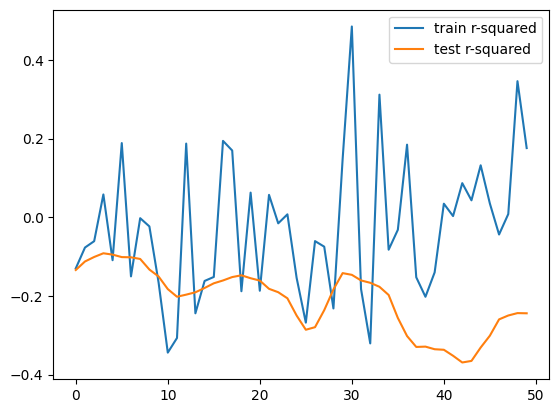

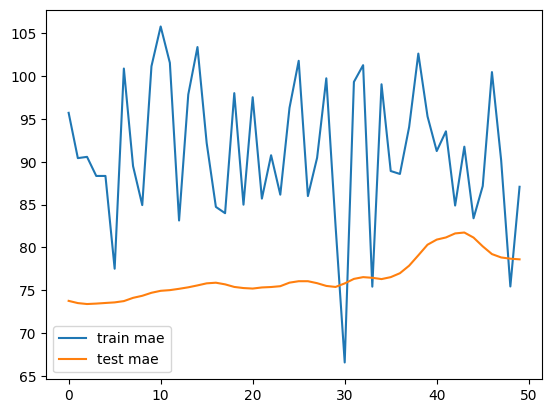

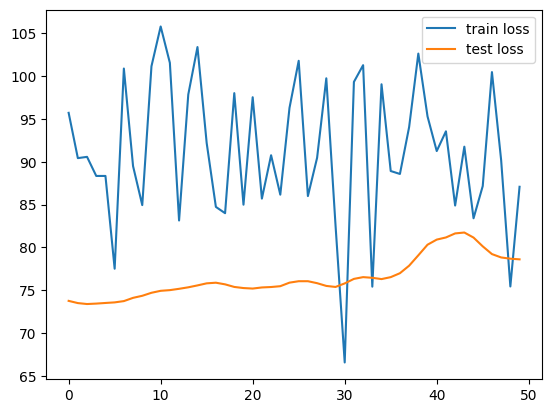

In [86]:
# plot history
import matplotlib.pyplot as plt

plt.plot(history.history['r_squared'], label='train r-squared')
plt.plot(history.history['val_r_squared'], label='test r-squared')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='test mae')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
